In [3]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  


In [4]:
# visualize optimization process

import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
import seaborn
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision import transforms

from torch.utils.data import TensorDataset
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import random
from sklearn.decomposition import PCA

In [5]:
# def seed_all(n=1337):
#   np.random.seed(n)
#   torch.manual_seed(n)
#   random.seed(n)

# seed_all(1288)

In [6]:
class Trainer:

    def __init__(self,
                 model: torch.nn.Module,
                 device: torch.device,
                 criterion: torch.nn.Module,
                 optimizer: torch.optim.Optimizer,
                 training_DataLoader: torch.utils.data.Dataset,
                 validation_DataLoader: None,
                 # lr_scheduler: torch.optim.lr_scheduler = None,
                 epochs: int = 100,
                 epoch: int = 0,
                 notebook: bool = False,
                 path2write: str = None,
                 save_best=False,
                 save_final=True,
                 save_interval=10,
                 checkpoint_start_epoch=50,
                 collect_weights = False
                 ):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        # self.lr_scheduler = lr_scheduler
        self.training_DataLoader = training_DataLoader
        self.validation_DataLoader = validation_DataLoader
        self.device = device
        self.epochs = epochs
        self.epoch = epoch
        self.notebook = notebook
        #             if self.notebook:
        #                 print('Notebook')
        #                 from tqdm.notebook import tqdm, trange
        #             else:
        #                 from tqdm import tqdm, trange
        self.path2write = path2write
        LOG_DIR = os.path.join(path2write, 'Log')  # path2write + 'Log/'
        self.writer_train = SummaryWriter(os.path.join(LOG_DIR, "train"))
        self.writer_val = SummaryWriter(os.path.join(LOG_DIR, "val"))
        self.check_point_path = os.path.join(path2write, 'check_points')
        if not os.path.exists(self.check_point_path):
            os.makedirs(self.check_point_path)
        self.save_best = save_best
        self.save_final = save_final
        self.save_interval = save_interval
        self.checkpoint_start_epoch = checkpoint_start_epoch
        self.training_loss = []
        self.validation_loss = []
        self.learning_rate = []
        self.training_accuracy = []
        self.validation_accuracy = []
        self.weight_layer_all_epoch = []
        self.weight_all_all_epoch = []
        self.weight_collection_accuracy = []
        self.collect_weights = collect_weights

    def run_trainer(self):
        self.model.to(self.device)
        #         print(next(self.model.parameters()).device)
        if self.notebook:
            print('Notebook')
            from tqdm.notebook import tqdm, trange
        else:
            from tqdm import tqdm, trange
        #         print(self.epochs)
        progressbar = trange(self.epochs, desc='Progress', disable=True)  # don't show progressbar
        loss_max = None
        for epoch in progressbar:
            print(f'Epoch - {epoch}')

            # Training Block
            train_loss, train_accuracy = self._train()
            self.writer_train.add_scalar("Train Loss", train_loss, epoch)
            self.writer_train.add_scalar("Train Accuracy", train_accuracy, epoch)


            # Val Block
            val_loss, val_accuracy = self._validate()
            self.writer_val.add_scalar("Val Loss", val_loss, epoch)
            self.writer_val.add_scalar("Val Accuracy", val_accuracy, epoch)

            # lr
            self.writer_train.add_scalar("Learning Rate", self.optimizer.param_groups[0]['lr'], epoch)

            print('Epoch - {} Train Loss - {:.6f} Val Loss - {:.6f} Train Accuracy - {:.6f} Val Accuracy - {:.6f}'.format(epoch, train_loss, val_loss, train_accuracy, val_accuracy))
            if self.save_final:
                if epoch == self.epochs-1:
                    model_name = 'epoch-{}-loss{:.6f}'.format(epoch, val_loss)
                    torch.save(self.model.state_dict(), os.path.join(self.check_point_path, model_name))

            # weights collections
            
            if self.collect_weights:
              if epoch%3 == 0:
                weights_layer_epoch = np.zeros(0)
                weights_all_epoch = np.zeros(0)
                for name, parameters in model.named_parameters():
                  if name == 'Dense1.weight':
                    weights_layer_epoch = np.concatenate((weights_layer_epoch, parameters.detach().cpu().numpy().reshape(-1)))
                  
                  if 'weight' in name:
                    weights_all_epoch = np.concatenate((weights_all_epoch, parameters.detach().cpu().numpy().reshape(-1)))

                self.weight_layer_all_epoch.append(weights_layer_epoch)
                self.weight_all_all_epoch.append(weights_all_epoch)
                self.weight_collection_accuracy.append(train_accuracy)
            
            loss_max = val_loss

        if self.collect_weights:
          return self.weight_layer_all_epoch, self.weight_all_all_epoch, self.weight_collection_accuracy, self.training_loss, self.validation_loss

        return self.training_loss, self.validation_loss, self.model, self.training_accuracy, self.validation_accuracy

    def _train(self):

        self.model.train()
        train_losses = []
        batch_iter = tqdm(enumerate(self.training_DataLoader), 'Training', total=len(self.training_DataLoader),
                          disable=False)
        batch_acc = 0
        for i, (x, y) in batch_iter:
            input, target = x.type(torch.float32).to(self.device), y.type(torch.float32).to(self.device)
            self.optimizer.zero_grad()
            target = target.type(torch.LongTensor).to(self.device)
            output = self.model(input)
            # target = target.unsqueeze(-1)
            # print('Target Shape - ', target.shape)
            # print('Output Shape - ', output.shape)
            loss = self.criterion(output, target)
            train_losses.append(loss.item())
            loss.backward()
            self.optimizer.step()
            pred = output.argmax(dim=1, keepdim=True) # max of prob
            pred = pred.flatten()
            # correct += pred.eq(target.view_as(pred)).sum().item() 
            batch_acc += torch.mean(pred.eq(target.view_as(pred)).type(torch.FloatTensor)).item()
            # batch_acc += (sum(pred.eq(target.view_as(pred)).type(torch.FloatTensor))/len(pred.eq(target.view_as(pred)).type(torch.FloatTensor)))
        accuracy = batch_acc/len(self.training_DataLoader)
        self.training_loss.append(np.mean(train_losses))  # Mean batch loss
        self.learning_rate.append(self.optimizer.param_groups[0]['lr'])
        self.training_accuracy.append(accuracy)

        batch_iter.close()  # clean up the bar
        return np.mean(train_losses), accuracy

    def _validate(self):

        self.model.eval()
        valid_losses = []
        batch_iter = tqdm(enumerate(self.validation_DataLoader), 'validation', total=len(self.validation_DataLoader), disable=False)
        batch_acc = 0
        for i, (x, y) in batch_iter:
            input, target = x.type(torch.float32).to(self.device), y.to(self.device)
            with torch.no_grad():
                output = self.model(input)
                # target = target.unsqueeze(-1)
                target = target.type(torch.LongTensor).to(self.device)
                loss = self.criterion(output, target)
                valid_losses.append(loss.item())
                pred = output.argmax(dim=1, keepdim=True)
                # correct += pred.eq(target.view_as(pred)).sum().item()
                batch_acc += torch.mean(pred.eq(target.view_as(pred)).type(torch.FloatTensor)).item()

        accuracy = batch_acc/len(self.validation_DataLoader)
        self.validation_loss.append(np.mean(valid_losses))
        self.validation_accuracy.append(accuracy)
        batch_iter.close()
        return np.mean(valid_losses), accuracy

In [7]:
class DNN0(nn.Module): #for mnist
  def __init__(self):
    super().__init__()
    self.Dense1 = nn.Linear(28*28, 64)
    self.Dense2 = nn.Linear(64, 32)
    self.Dense3 = nn.Linear(32, 16)
    self.Dense4 = nn.Linear(16, 10)

  def forward(self, x):
    x = x.view(x.shape[0], -1)
    x = self.Dense1(x)
    x = self.Dense2(x)
    x = self.Dense3(x)
    x = self.Dense4(x)
    out = F.log_softmax(x)

    return out


In [8]:
#dataset prepration
bath_size = 128

transform=transforms.Compose([
        transforms.ToTensor()
        ])
dataset1 = datasets.MNIST('Home work', train=True, download=True, transform=transform)
dataset2 = datasets.MNIST('Home work', train=False, transform=transform)

training_DataLoader = DataLoader(dataset1, batch_size=bath_size, shuffle=True)
validation_DataLoader= DataLoader(dataset2, batch_size=bath_size, shuffle=True)

In [9]:
gpu_id = 0
loss_fn = nn.CrossEntropyLoss()
lr = 1e-4
epochs =  16
notebook = True
checkpoint_start_epoch = 5 #Not using
path2write = "drive/MyDrive/DL_homework/"

In [10]:
def Weights_PCA(Weights):
  Weights = np.array(Weights)
  pca = PCA(n_components=2)
  pca.fit(Weights)
  princ_comps = pca.transform(Weights)
  return princ_comps

In [11]:
#collect weights at Dense1 (64), and weights of whole model
pca_layer = []
pca_all_layers = []
accuracies = []
for i in range(8):
  model = DNN0()
  optimizer = torch.optim.Adam(model.parameters(), lr = lr)
  trainer = Trainer(model=model,
                        device=gpu_id,
                        criterion=loss_fn,
                        optimizer=optimizer,
                        training_DataLoader=training_DataLoader,
                        validation_DataLoader=validation_DataLoader,
                        # lr_scheduler=lr_scheduler,
                        epochs=epochs,
                        epoch=0,
                        notebook=True,
                        path2write= path2write,
                        checkpoint_start_epoch=checkpoint_start_epoch,
                        collect_weights=True)

  weight_layer_all_epoch, weight_all_all_epoch, weight_collection_accuracy, training_loss, validation_loss = trainer.run_trainer()
  princ_comps_layer =  Weights_PCA(weight_layer_all_epoch)
  princ_all_layers = Weights_PCA(weight_all_all_epoch) 
  pca_layer.append(princ_comps_layer)
  pca_all_layers.append(princ_all_layers)
  accuracies.append(weight_collection_accuracy)



Notebook
Epoch - 0


Training:   0%|          | 0/469 [00:00<?, ?it/s]/local_scratch/slurm.707385/ipykernel_653943/3305374948.py:15: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = F.log_softmax(x)
validation: 100%|██████████| 79/79 [00:00<00:00, 102.07it/s]


Epoch - 0 Train Loss - 1.464161 Val Loss - 0.743358 Train Accuracy - 0.595210 Val Accuracy - 0.799644
Epoch - 1


validation: 100%|██████████| 79/79 [00:00<00:00, 98.53it/s]


Epoch - 1 Train Loss - 0.624215 Val Loss - 0.495923 Train Accuracy - 0.818175 Val Accuracy - 0.857694
Epoch - 2


validation: 100%|██████████| 79/79 [00:00<00:00, 101.17it/s]


Epoch - 2 Train Loss - 0.461407 Val Loss - 0.390688 Train Accuracy - 0.869775 Val Accuracy - 0.891911
Epoch - 3


validation: 100%|██████████| 79/79 [00:00<00:00, 100.87it/s]


Epoch - 3 Train Loss - 0.381741 Val Loss - 0.346283 Train Accuracy - 0.893090 Val Accuracy - 0.900218
Epoch - 4


validation: 100%|██████████| 79/79 [00:00<00:00, 100.92it/s]


Epoch - 4 Train Loss - 0.345712 Val Loss - 0.324445 Train Accuracy - 0.903179 Val Accuracy - 0.905953
Epoch - 5


validation: 100%|██████████| 79/79 [00:00<00:00, 100.72it/s]


Epoch - 5 Train Loss - 0.325975 Val Loss - 0.307446 Train Accuracy - 0.908949 Val Accuracy - 0.913172
Epoch - 6


validation: 100%|██████████| 79/79 [00:00<00:00, 110.03it/s]


Epoch - 6 Train Loss - 0.313166 Val Loss - 0.299069 Train Accuracy - 0.911553 Val Accuracy - 0.917326
Epoch - 7


validation: 100%|██████████| 79/79 [00:00<00:00, 109.87it/s]


Epoch - 7 Train Loss - 0.304288 Val Loss - 0.293926 Train Accuracy - 0.915167 Val Accuracy - 0.919502
Epoch - 8


validation: 100%|██████████| 79/79 [00:00<00:00, 114.48it/s]


Epoch - 8 Train Loss - 0.297904 Val Loss - 0.291051 Train Accuracy - 0.916867 Val Accuracy - 0.917623
Epoch - 9


validation: 100%|██████████| 79/79 [00:00<00:00, 116.18it/s]


Epoch - 9 Train Loss - 0.292721 Val Loss - 0.285355 Train Accuracy - 0.918394 Val Accuracy - 0.920194
Epoch - 10


validation: 100%|██████████| 79/79 [00:00<00:00, 116.60it/s]


Epoch - 10 Train Loss - 0.288133 Val Loss - 0.289178 Train Accuracy - 0.919454 Val Accuracy - 0.920886
Epoch - 11


validation: 100%|██████████| 79/79 [00:00<00:00, 102.06it/s]


Epoch - 11 Train Loss - 0.284184 Val Loss - 0.290335 Train Accuracy - 0.920720 Val Accuracy - 0.921381
Epoch - 12


validation: 100%|██████████| 79/79 [00:00<00:00, 97.76it/s]


Epoch - 12 Train Loss - 0.281073 Val Loss - 0.278523 Train Accuracy - 0.922491 Val Accuracy - 0.922271
Epoch - 13


validation: 100%|██████████| 79/79 [00:00<00:00, 94.73it/s]


Epoch - 13 Train Loss - 0.278068 Val Loss - 0.281011 Train Accuracy - 0.922886 Val Accuracy - 0.922765
Epoch - 14


validation: 100%|██████████| 79/79 [00:00<00:00, 96.44it/s]


Epoch - 14 Train Loss - 0.275168 Val Loss - 0.277957 Train Accuracy - 0.923380 Val Accuracy - 0.922468
Epoch - 15


validation: 100%|██████████| 79/79 [00:00<00:00, 94.66it/s]


Epoch - 15 Train Loss - 0.272870 Val Loss - 0.280213 Train Accuracy - 0.924224 Val Accuracy - 0.922369
Notebook
Epoch - 0


Training:   0%|          | 0/469 [00:00<?, ?it/s]/local_scratch/slurm.707385/ipykernel_653943/3305374948.py:15: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = F.log_softmax(x)
validation: 100%|██████████| 79/79 [00:00<00:00, 96.08it/s]


Epoch - 0 Train Loss - 1.518482 Val Loss - 0.746404 Train Accuracy - 0.576959 Val Accuracy - 0.809929
Epoch - 1


validation: 100%|██████████| 79/79 [00:00<00:00, 95.28it/s]


Epoch - 1 Train Loss - 0.598010 Val Loss - 0.463003 Train Accuracy - 0.833861 Val Accuracy - 0.870055
Epoch - 2


validation: 100%|██████████| 79/79 [00:00<00:00, 96.64it/s]


Epoch - 2 Train Loss - 0.433913 Val Loss - 0.376416 Train Accuracy - 0.877721 Val Accuracy - 0.892405
Epoch - 3


validation: 100%|██████████| 79/79 [00:00<00:00, 95.97it/s]


Epoch - 3 Train Loss - 0.374365 Val Loss - 0.339825 Train Accuracy - 0.894728 Val Accuracy - 0.902195
Epoch - 4


validation: 100%|██████████| 79/79 [00:00<00:00, 96.18it/s]


Epoch - 4 Train Loss - 0.346914 Val Loss - 0.328447 Train Accuracy - 0.901575 Val Accuracy - 0.904767
Epoch - 5


validation: 100%|██████████| 79/79 [00:00<00:00, 96.63it/s]


Epoch - 5 Train Loss - 0.331212 Val Loss - 0.318566 Train Accuracy - 0.905828 Val Accuracy - 0.910997
Epoch - 6


validation: 100%|██████████| 79/79 [00:00<00:00, 95.11it/s]


Epoch - 6 Train Loss - 0.320432 Val Loss - 0.303310 Train Accuracy - 0.909004 Val Accuracy - 0.915645
Epoch - 7


validation: 100%|██████████| 79/79 [00:00<00:00, 96.90it/s]


Epoch - 7 Train Loss - 0.312542 Val Loss - 0.297250 Train Accuracy - 0.911442 Val Accuracy - 0.915051
Epoch - 8


validation: 100%|██████████| 79/79 [00:00<00:00, 96.15it/s]


Epoch - 8 Train Loss - 0.306634 Val Loss - 0.296217 Train Accuracy - 0.912830 Val Accuracy - 0.917227
Epoch - 9


validation: 100%|██████████| 79/79 [00:00<00:00, 95.90it/s]


Epoch - 9 Train Loss - 0.301368 Val Loss - 0.289229 Train Accuracy - 0.914657 Val Accuracy - 0.919007
Epoch - 10


validation: 100%|██████████| 79/79 [00:00<00:00, 96.68it/s]


Epoch - 10 Train Loss - 0.296655 Val Loss - 0.288425 Train Accuracy - 0.915451 Val Accuracy - 0.919699
Epoch - 11


validation: 100%|██████████| 79/79 [00:00<00:00, 95.64it/s]


Epoch - 11 Train Loss - 0.292726 Val Loss - 0.287186 Train Accuracy - 0.916978 Val Accuracy - 0.919007
Epoch - 12


validation: 100%|██████████| 79/79 [00:00<00:00, 95.29it/s]


Epoch - 12 Train Loss - 0.289056 Val Loss - 0.282729 Train Accuracy - 0.917849 Val Accuracy - 0.921776
Epoch - 13


validation: 100%|██████████| 79/79 [00:00<00:00, 96.33it/s]


Epoch - 13 Train Loss - 0.285360 Val Loss - 0.283419 Train Accuracy - 0.919809 Val Accuracy - 0.920095
Epoch - 14


validation: 100%|██████████| 79/79 [00:00<00:00, 97.06it/s]


Epoch - 14 Train Loss - 0.282152 Val Loss - 0.277950 Train Accuracy - 0.920115 Val Accuracy - 0.921381
Epoch - 15


validation: 100%|██████████| 79/79 [00:00<00:00, 97.66it/s]


Epoch - 15 Train Loss - 0.279016 Val Loss - 0.274681 Train Accuracy - 0.921786 Val Accuracy - 0.921875
Notebook
Epoch - 0


Training:   0%|          | 0/469 [00:00<?, ?it/s]/local_scratch/slurm.707385/ipykernel_653943/3305374948.py:15: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = F.log_softmax(x)
validation: 100%|██████████| 79/79 [00:00<00:00, 95.07it/s]


Epoch - 0 Train Loss - 1.475146 Val Loss - 0.752174 Train Accuracy - 0.612834 Val Accuracy - 0.803797
Epoch - 1


validation: 100%|██████████| 79/79 [00:00<00:00, 97.63it/s]


Epoch - 1 Train Loss - 0.575542 Val Loss - 0.444798 Train Accuracy - 0.844905 Val Accuracy - 0.875593
Epoch - 2


validation: 100%|██████████| 79/79 [00:00<00:00, 97.05it/s]


Epoch - 2 Train Loss - 0.420589 Val Loss - 0.375862 Train Accuracy - 0.881075 Val Accuracy - 0.893295
Epoch - 3


validation: 100%|██████████| 79/79 [00:00<00:00, 95.83it/s]


Epoch - 3 Train Loss - 0.370259 Val Loss - 0.341402 Train Accuracy - 0.893784 Val Accuracy - 0.901404
Epoch - 4


validation: 100%|██████████| 79/79 [00:00<00:00, 96.60it/s]


Epoch - 4 Train Loss - 0.343853 Val Loss - 0.323355 Train Accuracy - 0.901863 Val Accuracy - 0.907437
Epoch - 5


validation: 100%|██████████| 79/79 [00:00<00:00, 96.75it/s]


Epoch - 5 Train Loss - 0.326946 Val Loss - 0.313706 Train Accuracy - 0.907011 Val Accuracy - 0.910700
Epoch - 6


validation: 100%|██████████| 79/79 [00:00<00:00, 93.92it/s]


Epoch - 6 Train Loss - 0.315259 Val Loss - 0.307306 Train Accuracy - 0.910492 Val Accuracy - 0.912975
Epoch - 7


validation: 100%|██████████| 79/79 [00:00<00:00, 96.72it/s]


Epoch - 7 Train Loss - 0.306284 Val Loss - 0.299224 Train Accuracy - 0.913807 Val Accuracy - 0.913667
Epoch - 8


validation: 100%|██████████| 79/79 [00:00<00:00, 95.93it/s]


Epoch - 8 Train Loss - 0.299217 Val Loss - 0.293736 Train Accuracy - 0.916089 Val Accuracy - 0.915447
Epoch - 9


validation: 100%|██████████| 79/79 [00:00<00:00, 95.53it/s]


Epoch - 9 Train Loss - 0.293382 Val Loss - 0.286123 Train Accuracy - 0.917322 Val Accuracy - 0.920787
Epoch - 10


validation: 100%|██████████| 79/79 [00:00<00:00, 96.39it/s]


Epoch - 10 Train Loss - 0.288319 Val Loss - 0.288318 Train Accuracy - 0.918865 Val Accuracy - 0.919798
Epoch - 11


validation: 100%|██████████| 79/79 [00:00<00:00, 95.68it/s]


Epoch - 11 Train Loss - 0.284234 Val Loss - 0.282929 Train Accuracy - 0.920465 Val Accuracy - 0.919600
Epoch - 12


validation: 100%|██████████| 79/79 [00:00<00:00, 99.73it/s] 


Epoch - 12 Train Loss - 0.280469 Val Loss - 0.285348 Train Accuracy - 0.921681 Val Accuracy - 0.921183
Epoch - 13


validation: 100%|██████████| 79/79 [00:00<00:00, 96.55it/s]


Epoch - 13 Train Loss - 0.277499 Val Loss - 0.277440 Train Accuracy - 0.922136 Val Accuracy - 0.923457
Epoch - 14


validation: 100%|██████████| 79/79 [00:00<00:00, 95.12it/s]


Epoch - 14 Train Loss - 0.274975 Val Loss - 0.274953 Train Accuracy - 0.922908 Val Accuracy - 0.924150
Epoch - 15


validation: 100%|██████████| 79/79 [00:00<00:00, 97.36it/s]


Epoch - 15 Train Loss - 0.272203 Val Loss - 0.273283 Train Accuracy - 0.923757 Val Accuracy - 0.924446
Notebook
Epoch - 0


Training:   0%|          | 0/469 [00:00<?, ?it/s]/local_scratch/slurm.707385/ipykernel_653943/3305374948.py:15: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = F.log_softmax(x)
validation: 100%|██████████| 79/79 [00:00<00:00, 95.28it/s]


Epoch - 0 Train Loss - 1.441434 Val Loss - 0.729803 Train Accuracy - 0.619320 Val Accuracy - 0.805775
Epoch - 1


validation: 100%|██████████| 79/79 [00:00<00:00, 96.87it/s]


Epoch - 1 Train Loss - 0.569934 Val Loss - 0.463781 Train Accuracy - 0.846998 Val Accuracy - 0.869363
Epoch - 2


validation: 100%|██████████| 79/79 [00:00<00:00, 98.46it/s] 


Epoch - 2 Train Loss - 0.430806 Val Loss - 0.394934 Train Accuracy - 0.880730 Val Accuracy - 0.884889
Epoch - 3


validation: 100%|██████████| 79/79 [00:00<00:00, 96.26it/s]


Epoch - 3 Train Loss - 0.380287 Val Loss - 0.358945 Train Accuracy - 0.893312 Val Accuracy - 0.897844
Epoch - 4


validation: 100%|██████████| 79/79 [00:00<00:00, 96.51it/s]


Epoch - 4 Train Loss - 0.352675 Val Loss - 0.340808 Train Accuracy - 0.900370 Val Accuracy - 0.903580
Epoch - 5


validation: 100%|██████████| 79/79 [00:00<00:00, 98.79it/s]


Epoch - 5 Train Loss - 0.335674 Val Loss - 0.324906 Train Accuracy - 0.905606 Val Accuracy - 0.906151
Epoch - 6


validation: 100%|██████████| 79/79 [00:00<00:00, 96.67it/s]


Epoch - 6 Train Loss - 0.323391 Val Loss - 0.315717 Train Accuracy - 0.908604 Val Accuracy - 0.910008
Epoch - 7


validation: 100%|██████████| 79/79 [00:00<00:00, 96.37it/s]


Epoch - 7 Train Loss - 0.314093 Val Loss - 0.310924 Train Accuracy - 0.911270 Val Accuracy - 0.909217
Epoch - 8


validation: 100%|██████████| 79/79 [00:00<00:00, 96.46it/s]


Epoch - 8 Train Loss - 0.306411 Val Loss - 0.300341 Train Accuracy - 0.914135 Val Accuracy - 0.915348
Epoch - 9


validation: 100%|██████████| 79/79 [00:00<00:00, 102.22it/s]


Epoch - 9 Train Loss - 0.300001 Val Loss - 0.296028 Train Accuracy - 0.916272 Val Accuracy - 0.915348
Epoch - 10


validation: 100%|██████████| 79/79 [00:00<00:00, 100.58it/s]


Epoch - 10 Train Loss - 0.294676 Val Loss - 0.291758 Train Accuracy - 0.917772 Val Accuracy - 0.917326
Epoch - 11


validation: 100%|██████████| 79/79 [00:00<00:00, 101.86it/s]


Epoch - 11 Train Loss - 0.290216 Val Loss - 0.291059 Train Accuracy - 0.918449 Val Accuracy - 0.917524
Epoch - 12


validation: 100%|██████████| 79/79 [00:00<00:00, 101.77it/s]


Epoch - 12 Train Loss - 0.286345 Val Loss - 0.286731 Train Accuracy - 0.919543 Val Accuracy - 0.919205
Epoch - 13


validation: 100%|██████████| 79/79 [00:00<00:00, 102.52it/s]


Epoch - 13 Train Loss - 0.283063 Val Loss - 0.285411 Train Accuracy - 0.920892 Val Accuracy - 0.920293
Epoch - 14


validation: 100%|██████████| 79/79 [00:00<00:00, 103.39it/s]


Epoch - 14 Train Loss - 0.280006 Val Loss - 0.283989 Train Accuracy - 0.921048 Val Accuracy - 0.920392
Epoch - 15


validation: 100%|██████████| 79/79 [00:00<00:00, 101.39it/s]


Epoch - 15 Train Loss - 0.277548 Val Loss - 0.284635 Train Accuracy - 0.922419 Val Accuracy - 0.920194
Notebook
Epoch - 0


Training:   0%|          | 0/469 [00:00<?, ?it/s]/local_scratch/slurm.707385/ipykernel_653943/3305374948.py:15: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = F.log_softmax(x)
validation: 100%|██████████| 79/79 [00:00<00:00, 100.91it/s]


Epoch - 0 Train Loss - 1.454517 Val Loss - 0.742128 Train Accuracy - 0.599963 Val Accuracy - 0.798655
Epoch - 1


validation: 100%|██████████| 79/79 [00:00<00:00, 102.75it/s]


Epoch - 1 Train Loss - 0.612886 Val Loss - 0.514347 Train Accuracy - 0.825493 Val Accuracy - 0.857298
Epoch - 2


validation: 100%|██████████| 79/79 [00:00<00:00, 101.48it/s]


Epoch - 2 Train Loss - 0.483764 Val Loss - 0.439860 Train Accuracy - 0.860374 Val Accuracy - 0.876088
Epoch - 3


validation: 100%|██████████| 79/79 [00:00<00:00, 100.93it/s]


Epoch - 3 Train Loss - 0.426449 Val Loss - 0.390229 Train Accuracy - 0.877082 Val Accuracy - 0.887757
Epoch - 4


validation: 100%|██████████| 79/79 [00:00<00:00, 101.75it/s]


Epoch - 4 Train Loss - 0.387375 Val Loss - 0.357368 Train Accuracy - 0.889109 Val Accuracy - 0.897844
Epoch - 5


validation: 100%|██████████| 79/79 [00:00<00:00, 103.08it/s]


Epoch - 5 Train Loss - 0.356764 Val Loss - 0.330282 Train Accuracy - 0.898765 Val Accuracy - 0.905953
Epoch - 6


validation: 100%|██████████| 79/79 [00:00<00:00, 102.05it/s]


Epoch - 6 Train Loss - 0.333867 Val Loss - 0.313236 Train Accuracy - 0.906033 Val Accuracy - 0.912184
Epoch - 7


validation: 100%|██████████| 79/79 [00:00<00:00, 102.84it/s]


Epoch - 7 Train Loss - 0.317925 Val Loss - 0.300442 Train Accuracy - 0.910326 Val Accuracy - 0.913568
Epoch - 8


validation: 100%|██████████| 79/79 [00:00<00:00, 101.60it/s]


Epoch - 8 Train Loss - 0.306963 Val Loss - 0.292864 Train Accuracy - 0.913346 Val Accuracy - 0.915447
Epoch - 9


validation: 100%|██████████| 79/79 [00:00<00:00, 101.88it/s]


Epoch - 9 Train Loss - 0.299031 Val Loss - 0.289569 Train Accuracy - 0.915956 Val Accuracy - 0.917524
Epoch - 10


validation: 100%|██████████| 79/79 [00:00<00:00, 102.09it/s]


Epoch - 10 Train Loss - 0.292727 Val Loss - 0.288367 Train Accuracy - 0.917888 Val Accuracy - 0.918513
Epoch - 11


validation: 100%|██████████| 79/79 [00:00<00:00, 103.09it/s]


Epoch - 11 Train Loss - 0.287863 Val Loss - 0.280499 Train Accuracy - 0.919415 Val Accuracy - 0.921776
Epoch - 12


validation: 100%|██████████| 79/79 [00:00<00:00, 101.39it/s]


Epoch - 12 Train Loss - 0.283655 Val Loss - 0.277072 Train Accuracy - 0.921053 Val Accuracy - 0.922567
Epoch - 13


validation: 100%|██████████| 79/79 [00:00<00:00, 101.28it/s]


Epoch - 13 Train Loss - 0.280255 Val Loss - 0.276582 Train Accuracy - 0.921103 Val Accuracy - 0.922567
Epoch - 14


validation: 100%|██████████| 79/79 [00:00<00:00, 102.70it/s]


Epoch - 14 Train Loss - 0.277466 Val Loss - 0.280663 Train Accuracy - 0.922586 Val Accuracy - 0.922666
Epoch - 15


validation: 100%|██████████| 79/79 [00:00<00:00, 96.97it/s] 


Epoch - 15 Train Loss - 0.274195 Val Loss - 0.274272 Train Accuracy - 0.923724 Val Accuracy - 0.923358
Notebook
Epoch - 0


Training:   0%|          | 0/469 [00:00<?, ?it/s]/local_scratch/slurm.707385/ipykernel_653943/3305374948.py:15: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = F.log_softmax(x)
validation: 100%|██████████| 79/79 [00:00<00:00, 98.70it/s] 


Epoch - 0 Train Loss - 1.415984 Val Loss - 0.744397 Train Accuracy - 0.607437 Val Accuracy - 0.802116
Epoch - 1


validation: 100%|██████████| 79/79 [00:00<00:00, 98.10it/s] 


Epoch - 1 Train Loss - 0.599131 Val Loss - 0.485633 Train Accuracy - 0.835305 Val Accuracy - 0.866001
Epoch - 2


validation: 100%|██████████| 79/79 [00:00<00:00, 99.39it/s] 


Epoch - 2 Train Loss - 0.454004 Val Loss - 0.404924 Train Accuracy - 0.873606 Val Accuracy - 0.890328
Epoch - 3


validation: 100%|██████████| 79/79 [00:00<00:00, 99.75it/s] 


Epoch - 3 Train Loss - 0.394990 Val Loss - 0.364188 Train Accuracy - 0.889653 Val Accuracy - 0.899822
Epoch - 4


validation: 100%|██████████| 79/79 [00:00<00:00, 100.36it/s]


Epoch - 4 Train Loss - 0.358996 Val Loss - 0.334707 Train Accuracy - 0.900081 Val Accuracy - 0.908129
Epoch - 5


validation: 100%|██████████| 79/79 [00:00<00:00, 98.89it/s] 


Epoch - 5 Train Loss - 0.334984 Val Loss - 0.313212 Train Accuracy - 0.906478 Val Accuracy - 0.911788
Epoch - 6


validation: 100%|██████████| 79/79 [00:00<00:00, 97.15it/s] 


Epoch - 6 Train Loss - 0.318500 Val Loss - 0.301490 Train Accuracy - 0.910553 Val Accuracy - 0.915843
Epoch - 7


validation: 100%|██████████| 79/79 [00:00<00:00, 99.86it/s] 


Epoch - 7 Train Loss - 0.306948 Val Loss - 0.292912 Train Accuracy - 0.913396 Val Accuracy - 0.918315
Epoch - 8


validation: 100%|██████████| 79/79 [00:00<00:00, 98.12it/s] 


Epoch - 8 Train Loss - 0.298788 Val Loss - 0.287140 Train Accuracy - 0.916017 Val Accuracy - 0.920194
Epoch - 9


validation: 100%|██████████| 79/79 [00:00<00:00, 100.78it/s]


Epoch - 9 Train Loss - 0.292770 Val Loss - 0.282524 Train Accuracy - 0.917550 Val Accuracy - 0.919996
Epoch - 10


validation: 100%|██████████| 79/79 [00:00<00:00, 104.76it/s]


Epoch - 10 Train Loss - 0.287875 Val Loss - 0.282839 Train Accuracy - 0.919260 Val Accuracy - 0.918710
Epoch - 11


validation: 100%|██████████| 79/79 [00:00<00:00, 103.99it/s]


Epoch - 11 Train Loss - 0.284035 Val Loss - 0.277066 Train Accuracy - 0.920442 Val Accuracy - 0.922567
Epoch - 12


validation: 100%|██████████| 79/79 [00:00<00:00, 100.72it/s]


Epoch - 12 Train Loss - 0.280606 Val Loss - 0.282499 Train Accuracy - 0.920964 Val Accuracy - 0.922765
Epoch - 13


validation: 100%|██████████| 79/79 [00:00<00:00, 88.89it/s]


Epoch - 13 Train Loss - 0.277921 Val Loss - 0.274823 Train Accuracy - 0.922169 Val Accuracy - 0.924051
Epoch - 14


validation: 100%|██████████| 79/79 [00:00<00:00, 109.81it/s]


Epoch - 14 Train Loss - 0.275331 Val Loss - 0.273120 Train Accuracy - 0.922913 Val Accuracy - 0.924347
Epoch - 15


validation: 100%|██████████| 79/79 [00:00<00:00, 111.30it/s]


Epoch - 15 Train Loss - 0.273297 Val Loss - 0.278572 Train Accuracy - 0.923718 Val Accuracy - 0.923259
Notebook
Epoch - 0


Training:   0%|          | 0/469 [00:00<?, ?it/s]/local_scratch/slurm.707385/ipykernel_653943/3305374948.py:15: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = F.log_softmax(x)
validation: 100%|██████████| 79/79 [00:00<00:00, 111.26it/s]


Epoch - 0 Train Loss - 1.481558 Val Loss - 0.786650 Train Accuracy - 0.579341 Val Accuracy - 0.795293
Epoch - 1


validation: 100%|██████████| 79/79 [00:00<00:00, 111.70it/s]


Epoch - 1 Train Loss - 0.613171 Val Loss - 0.492700 Train Accuracy - 0.827314 Val Accuracy - 0.859177
Epoch - 2


validation: 100%|██████████| 79/79 [00:00<00:00, 111.58it/s]


Epoch - 2 Train Loss - 0.463929 Val Loss - 0.416207 Train Accuracy - 0.864522 Val Accuracy - 0.875791
Epoch - 3


validation: 100%|██████████| 79/79 [00:00<00:00, 112.22it/s]


Epoch - 3 Train Loss - 0.412994 Val Loss - 0.381657 Train Accuracy - 0.879625 Val Accuracy - 0.885087
Epoch - 4


validation: 100%|██████████| 79/79 [00:00<00:00, 112.02it/s]


Epoch - 4 Train Loss - 0.381527 Val Loss - 0.359775 Train Accuracy - 0.890159 Val Accuracy - 0.894680
Epoch - 5


validation: 100%|██████████| 79/79 [00:00<00:00, 111.87it/s]


Epoch - 5 Train Loss - 0.357465 Val Loss - 0.338882 Train Accuracy - 0.897899 Val Accuracy - 0.899822
Epoch - 6


validation: 100%|██████████| 79/79 [00:00<00:00, 111.59it/s]


Epoch - 6 Train Loss - 0.338485 Val Loss - 0.323314 Train Accuracy - 0.903551 Val Accuracy - 0.906448
Epoch - 7


validation: 100%|██████████| 79/79 [00:00<00:00, 110.92it/s]


Epoch - 7 Train Loss - 0.323781 Val Loss - 0.310630 Train Accuracy - 0.907921 Val Accuracy - 0.909217
Epoch - 8


validation: 100%|██████████| 79/79 [00:00<00:00, 112.14it/s]


Epoch - 8 Train Loss - 0.313101 Val Loss - 0.302825 Train Accuracy - 0.910853 Val Accuracy - 0.910997
Epoch - 9


validation: 100%|██████████| 79/79 [00:00<00:00, 111.08it/s]


Epoch - 9 Train Loss - 0.304483 Val Loss - 0.294612 Train Accuracy - 0.913357 Val Accuracy - 0.914458
Epoch - 10


validation: 100%|██████████| 79/79 [00:00<00:00, 111.41it/s]


Epoch - 10 Train Loss - 0.297790 Val Loss - 0.289189 Train Accuracy - 0.915739 Val Accuracy - 0.916337
Epoch - 11


validation: 100%|██████████| 79/79 [00:00<00:00, 108.30it/s]


Epoch - 11 Train Loss - 0.292074 Val Loss - 0.289826 Train Accuracy - 0.917811 Val Accuracy - 0.916634
Epoch - 12


validation: 100%|██████████| 79/79 [00:00<00:00, 108.66it/s]


Epoch - 12 Train Loss - 0.286868 Val Loss - 0.285401 Train Accuracy - 0.919071 Val Accuracy - 0.916831
Epoch - 13


validation: 100%|██████████| 79/79 [00:00<00:00, 107.29it/s]


Epoch - 13 Train Loss - 0.282370 Val Loss - 0.280372 Train Accuracy - 0.920692 Val Accuracy - 0.919403
Epoch - 14


validation: 100%|██████████| 79/79 [00:00<00:00, 107.74it/s]


Epoch - 14 Train Loss - 0.278220 Val Loss - 0.277859 Train Accuracy - 0.922180 Val Accuracy - 0.919502
Epoch - 15


validation: 100%|██████████| 79/79 [00:00<00:00, 106.21it/s]


Epoch - 15 Train Loss - 0.274732 Val Loss - 0.276646 Train Accuracy - 0.923141 Val Accuracy - 0.920095
Notebook
Epoch - 0


Training:   0%|          | 0/469 [00:00<?, ?it/s]/local_scratch/slurm.707385/ipykernel_653943/3305374948.py:15: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = F.log_softmax(x)
validation: 100%|██████████| 79/79 [00:00<00:00, 105.72it/s]


Epoch - 0 Train Loss - 1.484094 Val Loss - 0.783313 Train Accuracy - 0.557536 Val Accuracy - 0.809237
Epoch - 1


validation: 100%|██████████| 79/79 [00:00<00:00, 107.24it/s]


Epoch - 1 Train Loss - 0.590974 Val Loss - 0.463509 Train Accuracy - 0.840546 Val Accuracy - 0.868078
Epoch - 2


validation: 100%|██████████| 79/79 [00:00<00:00, 109.13it/s]


Epoch - 2 Train Loss - 0.431038 Val Loss - 0.386253 Train Accuracy - 0.877948 Val Accuracy - 0.888845
Epoch - 3


validation: 100%|██████████| 79/79 [00:00<00:00, 110.38it/s]


Epoch - 3 Train Loss - 0.376768 Val Loss - 0.348605 Train Accuracy - 0.892291 Val Accuracy - 0.899130
Epoch - 4


validation: 100%|██████████| 79/79 [00:00<00:00, 109.51it/s]


Epoch - 4 Train Loss - 0.348223 Val Loss - 0.328333 Train Accuracy - 0.900270 Val Accuracy - 0.905162
Epoch - 5


validation: 100%|██████████| 79/79 [00:00<00:00, 105.92it/s]


Epoch - 5 Train Loss - 0.330485 Val Loss - 0.321667 Train Accuracy - 0.905251 Val Accuracy - 0.908030
Epoch - 6


validation: 100%|██████████| 79/79 [00:00<00:00, 105.49it/s]


Epoch - 6 Train Loss - 0.318006 Val Loss - 0.311532 Train Accuracy - 0.909132 Val Accuracy - 0.909711
Epoch - 7


validation: 100%|██████████| 79/79 [00:00<00:00, 106.30it/s]


Epoch - 7 Train Loss - 0.309309 Val Loss - 0.300094 Train Accuracy - 0.912141 Val Accuracy - 0.912678
Epoch - 8


validation: 100%|██████████| 79/79 [00:00<00:00, 106.99it/s]


Epoch - 8 Train Loss - 0.302151 Val Loss - 0.299141 Train Accuracy - 0.913907 Val Accuracy - 0.913469
Epoch - 9


validation: 100%|██████████| 79/79 [00:00<00:00, 108.67it/s]


Epoch - 9 Train Loss - 0.296281 Val Loss - 0.293077 Train Accuracy - 0.915390 Val Accuracy - 0.914656
Epoch - 10


validation: 100%|██████████| 79/79 [00:00<00:00, 107.55it/s]


Epoch - 10 Train Loss - 0.291155 Val Loss - 0.290132 Train Accuracy - 0.917733 Val Accuracy - 0.918018
Epoch - 11


validation: 100%|██████████| 79/79 [00:00<00:00, 107.95it/s]


Epoch - 11 Train Loss - 0.286380 Val Loss - 0.282830 Train Accuracy - 0.919349 Val Accuracy - 0.919600
Epoch - 12


validation: 100%|██████████| 79/79 [00:00<00:00, 109.88it/s]


Epoch - 12 Train Loss - 0.282295 Val Loss - 0.280766 Train Accuracy - 0.920193 Val Accuracy - 0.921183
Epoch - 13


validation: 100%|██████████| 79/79 [00:00<00:00, 109.39it/s]


Epoch - 13 Train Loss - 0.279074 Val Loss - 0.281981 Train Accuracy - 0.922047 Val Accuracy - 0.921381
Epoch - 14


validation: 100%|██████████| 79/79 [00:00<00:00, 106.91it/s]


Epoch - 14 Train Loss - 0.275003 Val Loss - 0.279614 Train Accuracy - 0.922441 Val Accuracy - 0.921183
Epoch - 15


validation: 100%|██████████| 79/79 [00:00<00:00, 106.97it/s]

Epoch - 15 Train Loss - 0.272193 Val Loss - 0.273954 Train Accuracy - 0.923241 Val Accuracy - 0.922468


In [12]:
def plot_pca(pca_layer, accuracies, plot_name):
  fig = plt.figure(figsize=(15,15))
  plt.xlabel('Weight PC1')
  plt.ylabel('Weight PC2')
  plt.title(plot_name)
  for i in range(8):
    W_i = pca_layer[i]
    plt.scatter(W_i[:,0], W_i[:,1])
    for j in range(len(W_i)):
      plt.annotate(round(accuracies[i][j],1), (W_i[j,0],W_i[j,1]))
  plt.show()
  fig.savefig(os.path.join(path2write, plot_name))

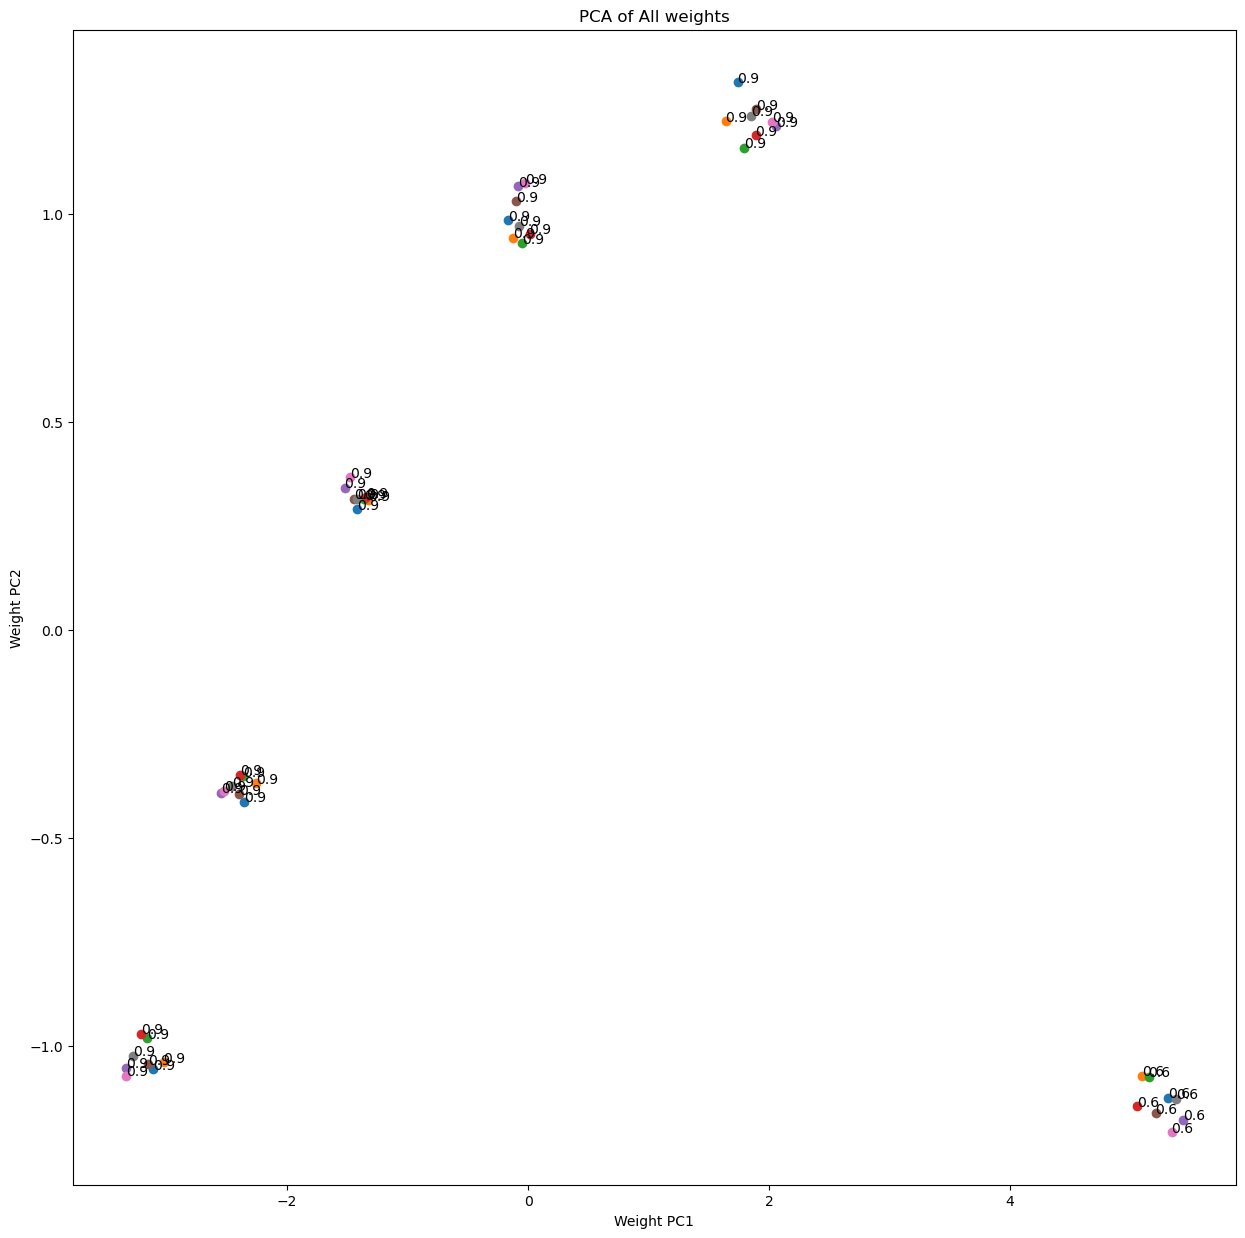

In [13]:
plot_pca(pca_all_layers, accuracies, 'PCA of All weights')

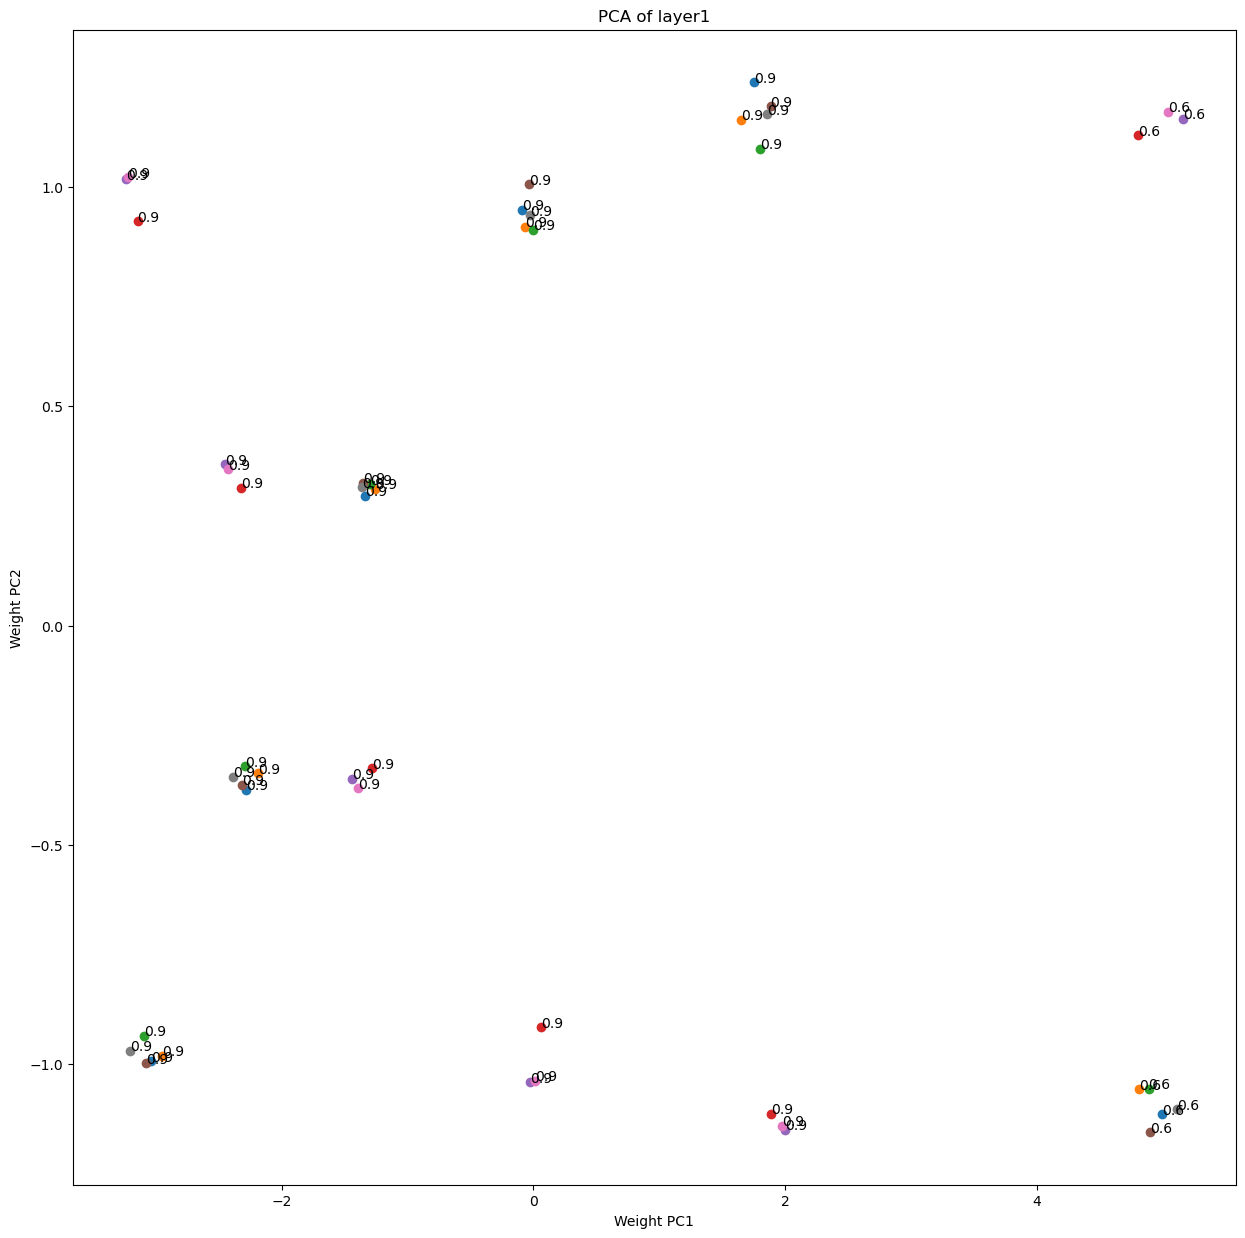

In [14]:
plot_pca(pca_layer, accuracies, 'PCA of layer1')

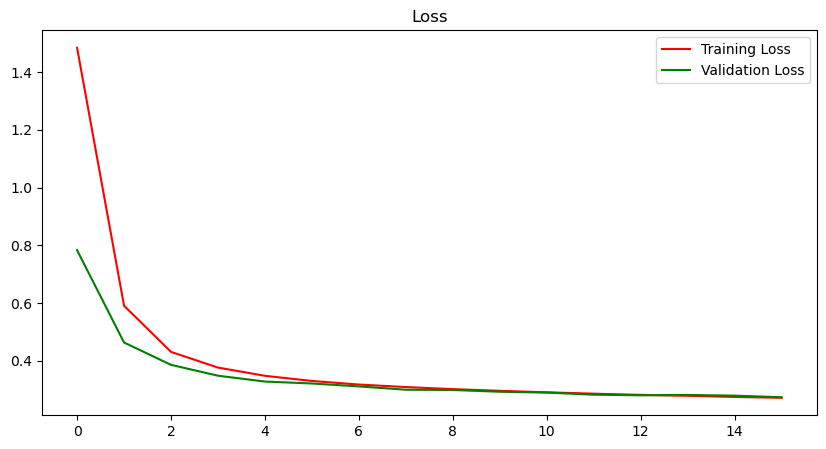

In [15]:
training_loss, validation_loss
fig = plt.figure(figsize=(10,5))

ax1 = fig.add_subplot(1,1,1)
ax1.plot(training_loss, 'r-', label='Training Loss')
ax1.plot(validation_loss, 'g-', label='Validation Loss')
ax1.legend()
ax1.set_title('Loss')
fig.savefig(os.path.join(path2write, 'PCA Training Loss.png'))

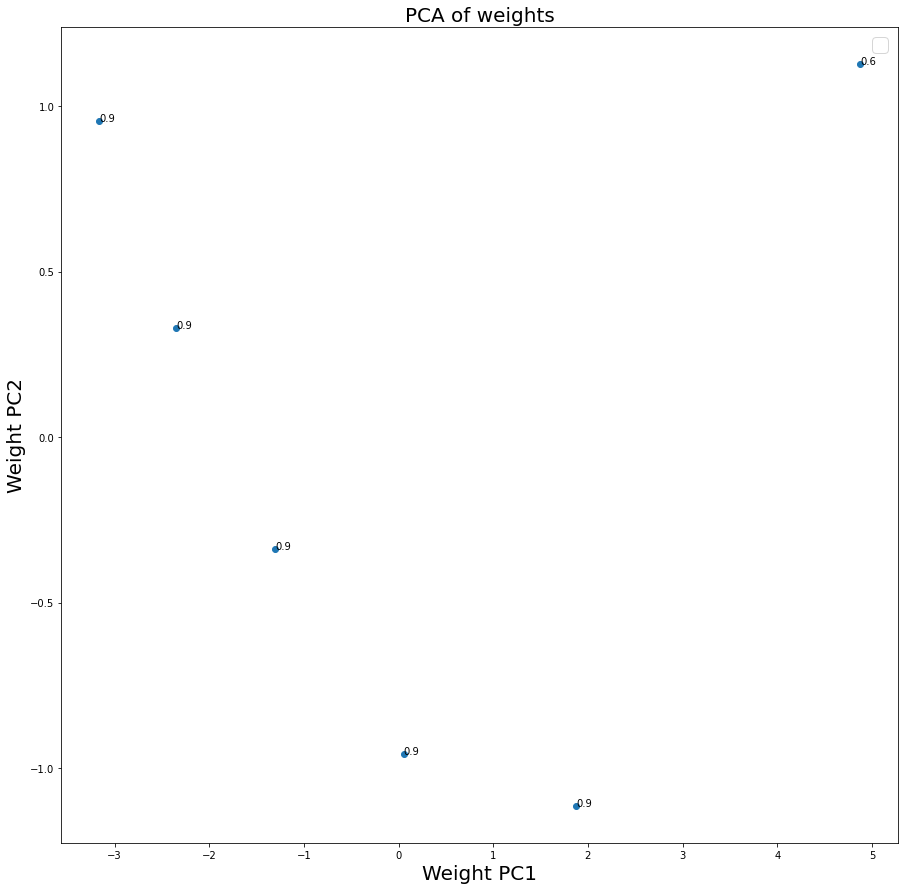

In [ ]:
# plt.figure(figsize=(15,15))
# plt.xlabel('Weight PC1',fontsize=20)
# plt.ylabel('Weight PC2',fontsize=20)
# plt.title('PCA of weights',fontsize=20)
# plt.legend(fontsize=20)
# for i in range(8):
#   W_i = pca_layer[i]
#   plt.scatter(W_i[:,0], W_i[:,1])
#   for j in range(len(W_i)):
#     plt.annotate(round(accuracies[i][j].item(),1), (W_i[j,0],W_i[j,1]))
#   break
# plt.show()

# plt.figure(figsize=(20,10))
# plt.xlabel('Weight1',fontsize=20)
# plt.ylabel('Weight2',fontsize=20)
# plt.title('Weights of our layer',fontsize=20)
# for i in range(events):
# W_i = W2[i]
# plt.scatter(W_i[:,0], W_i[:,1])
# for j in range(len(W_i)):
# plt.annotate(round(W_loss[i][j],1), (W_i[j,0],W_i[j,1]))
# plt.show()